# Recommender Systems Project

## Requirements

In [3]:
import pandas as pd
import numpy as np
import random, time
import matplotlib.pyplot as plt
from typing import List, Tuple
from tqdm import tqdm

# Data Collection and Preprocessing

- Download the MovieLens and IMDb datasets.
- Merge datasets to include movie ratings, genres, and metadata.

## Datasets 

The Datasets used are:
- **MovieLens Dataset**: [MovieLens](https://grouplens.org/datasets/movielens/)
    - movies.dat
    - ratings.dat
    - users.dat

- **IMDb Dataset**: [IMDb Datasets](https://www.imdb.com/interfaces/)
    - title.basics.tsv
    - name.basics.tsv

## Loading and visualization (MovieLens)

In this step, we are first loading the MovieLens dataset. We will use the pandas library to read this dataset into a DataFrame for easier manipulation and analysis.

In [6]:
# Function to get the summary of a Dataframe if the case where analysis=True
def get_summary(df, name, analysis=False):
    print('Name:', name, ', Length:', len(df))
    display(df)

    if not analysis:
        return
    df_summary = pd.DataFrame({
        'dtype': df.dtypes,
        'unique':df.nunique().values,
        'missing': df.isna().sum().values,
        'duplicates': df.duplicated().sum(),
    })
    return df_summary.style.background_gradient(cmap='viridis_r',low=0.8)

In [8]:
# Load MovieLens data
df_users = pd.read_csv("../data/ml-1m/users.dat", sep="::", engine='python', header=None)
df_users.columns = ['UserId', 'Gender', 'Age', 'Occupation', 'Zip-code']
df_users.set_index("UserId", inplace=True)

df_movies = pd.read_csv("../data/ml-1m/movies.dat", sep="::", engine='python', header=None, encoding='latin1')
df_movies.columns = ['MovieId', 'Title', 'Genres']
df_movies.set_index("MovieId", inplace=True)

df_ratings = pd.read_csv("../data/ml-1m/ratings.dat", sep="::", engine='python', header=None)
df_ratings.columns = ['UserId', 'MovieId', 'Rating', 'Timestamp']

In [10]:
get_summary(df_users, 'df_users', analysis=True)

Name: df_users , Length: 6040


,Gender,Age,Occupation,Zip-code
UserId,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455
...,...,...,...,...
6036,F,25,15,32603
6037,F,45,1,76006
6038,F,56,1,14706


,dtype,unique,missing,duplicates
Gender,object,2,0,244
Age,int64,7,0,244
Occupation,int64,21,0,244
Zip-code,object,3439,0,244


In [11]:
get_summary(df_movies, 'df_movies', analysis=True)

Name: df_movies , Length: 3883


,Title,Genres
MovieId,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy
...,...,...
3948,Meet the Parents (2000),Comedy
3949,Requiem for a Dream (2000),Drama
3950,Tigerland (2000),Drama


,dtype,unique,missing,duplicates
Title,object,3883,0,0
Genres,object,301,0,0


In [12]:
get_summary(df_ratings, 'df_ratings', analysis=True)

Name: df_ratings , Length: 1000209


,UserId,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


,dtype,unique,missing,duplicates
UserId,int64,6040,0,0
MovieId,int64,3706,0,0
Rating,int64,5,0,0
Timestamp,int64,458455,0,0


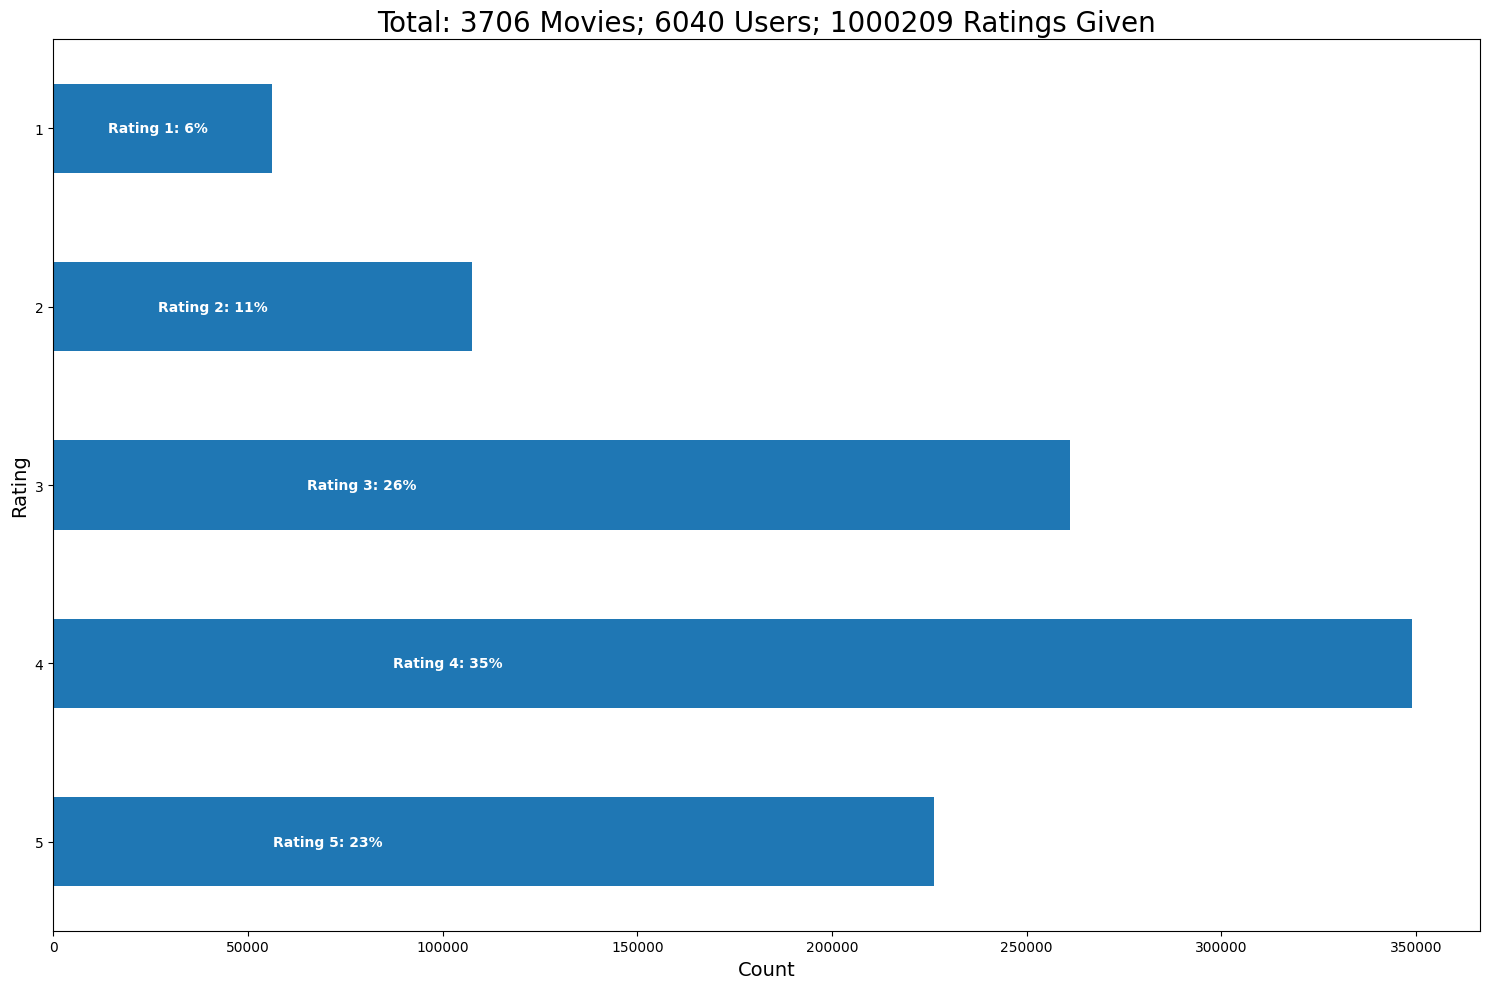

In [15]:
# Calculate rating counts
rating_counts = df_ratings['Rating'].value_counts().sort_index()

unique_movie_count = df_ratings['MovieId'].nunique()
unique_user_count = df_ratings['UserId'].nunique()

fig, ax = plt.subplots(figsize=(15, 10))
rating_counts.plot(kind='barh', legend=False, ax=ax)

total_rating_count = df_ratings.shape[0]
plt.title(f'Total: {unique_movie_count} Movies; {unique_user_count} Users; {total_rating_count} Ratings Given', fontsize=20)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Rating', fontsize=14)
ax.invert_yaxis()

for i, (rating, count) in enumerate(rating_counts.items()):
    percentage = count * 100 / total_rating_count
    ax.text(count / 4, i, f'Rating {rating}: {percentage:.0f}%', color='white', weight='bold', va='center')

plt.tight_layout()
plt.show()

## Preprocessing (MovieLens)

First, we will remove columns from the dataframes that could introduce biases into our models. Specifically, we will delete the column `Timestamp` from **df_ratings** (we are not going to make analysis based on recent/old ratings) and `Zip-code` (it will not be usefull for our use case)

In [16]:
df_ratings.drop(columns=['Timestamp'], inplace=True)
df_users.drop(columns=['Zip-code'], inplace=True)

To continue with **df_movies**, we are going to: 

1. Extract the release year from the movie titles and add it as a separate column (`Date`).

For example :

`Jumanji (1995)` will become:

- **Title**: Jumanji
- **Date**: 1995
2. Correct the Titles patterns to make them 'match' with the one inside imdb

Indeed, some titles have a structure where a definite article is placed at the end, for example, "American President, The". Additionally, we will remove any unnecessary information within parentheses, such as alternative titles or additional descriptors, to match the format used in IMDb.

For example:

- `Contender, The` will become `The Contender`
- `Silence of the Palace, The (Saimt el Qusur)` will become `The Silence of the Palace`

In [17]:
df_movies.reset_index(inplace=True)
df_movies['Date'] = df_movies['Title'].str.extract(r'\((\d{4})\)')
df_movies['Title'] = df_movies['Title'].str.replace(r'\s\(\d{4}\)', '', regex=True)
df_movies['Title'] = df_movies['Title'].str.replace(r'\s*\([^)]*\)', '', regex=True)
df_movies['Title'] = df_movies['Title'].str.replace(r"(.+),\s(The|Les|An|A|L'|La|Das|Il|Le|Der|Die|I|El)$", r'\2 \1', regex=True)
df_movies['Date'] = df_movies['Date'].astype(float)
get_summary(df_movies, 'df_movies')

Name: df_movies , Length: 3883


,MovieId,Title,Genres,Date
0,1,Toy Story,Animation|Children's|Comedy,1995.0
1,2,Jumanji,Adventure|Children's|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0
...,...,...,...,...
3878,3948,Meet the Parents,Comedy,2000.0
3879,3949,Requiem for a Dream,Drama,2000.0
3880,3950,Tigerland,Drama,2000.0
3881,3951,Two Family House,Drama,2000.0


## Loading and visualization (IMDb)


Next, we load the IMDb dataset. The dataset is in a tab-separated values (TSV) file format. We will use the pandas library to read this dataset into a DataFrame for easier manipulation and analysis.

In [19]:
# Load IMDb dataset
imdb_title_basics = pd.read_csv('../data/imdb/title.basics.tsv', sep="\t", na_values="\\N", low_memory=False)
imdb_name_basics = pd.read_csv('../data/imdb/name.basics.tsv', sep="\t", na_values="\\N", low_memory=False)

In [20]:
get_summary(imdb_title_basics, 'imdb_title_basics', analysis=True)

Name: imdb_title_basics , Length: 10904346


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0.0,1894.0,NaN,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10904341,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0.0,2009.0,NaN,NaN,"Action,Drama,Family"
10904342,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0.0,2010.0,NaN,NaN,"Action,Drama,Family"
10904343,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0.0,2010.0,NaN,NaN,"Action,Drama,Family"
10904344,tt9916856,short,The Wind,The Wind,0.0,2015.0,NaN,27,Short


,dtype,unique,missing,duplicates
tconst,object,10904346,0,0
titleType,object,11,0,0
primaryTitle,object,4907276,18,0
originalTitle,object,4931053,18,0
isAdult,float64,41,1,0
startYear,float64,151,1414728,0
endYear,float64,96,10778284,0
runtimeMinutes,object,906,7517622,0
genres,object,2374,484495,0


In [21]:
get_summary(imdb_name_basics, 'imdb_name_basics', analysis=True)

Name: imdb_name_basics , Length: 13616649


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467"
...,...,...,...,...,...,...
13616644,nm9993714,Romeo del Rosario,NaN,NaN,"animation_department,art_department","tt11657662,tt14069590,tt2455546"
13616645,nm9993716,Essias Loberg,NaN,NaN,NaN,NaN
13616646,nm9993717,Harikrishnan Rajan,NaN,NaN,cinematographer,tt8736744
13616647,nm9993718,Aayush Nair,NaN,NaN,cinematographer,tt8736744


,dtype,unique,missing,duplicates
nconst,object,13616649,0,0
primaryName,object,10479239,57,0
birthYear,float64,541,12997476,0
deathYear,float64,484,13385906,0
primaryProfession,object,22906,2622472,0
knownForTitles,object,5687871,1510252,0


## Preprocessing (IMDb)
### imdb_title_basics

`tilteType` can be :

- short
- tvEpisode
- tvMovie
- movie

In this step, we are goind to first filter the dataset to include only the movies `titleType` = `movie`.

We will then clean the dataset by removing unnecessary columns, such as:

- titleType
- originalTitle
- endYear

These columns are either not relevant to our analysis or contain redundant information. By removing these columns, we simplify our dataset, making it easier to work with and focus on the essential information for our analysis.

In [22]:
imdb_title_basics = imdb_title_basics[imdb_title_basics['titleType'] == 'movie']
imdb_title_basics.drop(columns=['endYear', 'titleType', 'originalTitle'], inplace=True)
imdb_title_basics

,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,0.0,1894.0,45,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,0.0,1897.0,100,"Documentary,News,Sport"
498,tt0000502,Bohemios,0.0,1905.0,100,NaN
570,tt0000574,The Story of the Kelly Gang,0.0,1906.0,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,0.0,1907.0,90,Drama
...,...,...,...,...,...,...
10904237,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,0.0,2015.0,57,Documentary
10904264,tt9916680,De la ilusión al desconcierto: cine colombiano...,0.0,2007.0,100,Documentary
10904276,tt9916706,Dankyavar Danka,0.0,2013.0,NaN,Comedy
10904286,tt9916730,6 Gunn,0.0,2017.0,116,Drama


Now it's time to merge our two datasets, **imdb_title_basics** and **df_movies**. The goal is to enrich **df_movies** with additional data from **imdb_title_basics** to have higher quality data for the future.

The merge will be performed on the movie title and release date for both datasets, using the following keys:
- `Title` and `Date` for **df_movies**
- `primaryTitle` and `startYear` for **imdb_title_basics**

The additional key `Date` is used to avoid mistakenly including other films with the same title but from different years in the merge (to avoid including erroneous data).

In [23]:
df_movies = df_movies.merge(imdb_title_basics, left_on=['Title', 'Date'], right_on=['primaryTitle', 'startYear'], how='left')
df_movies.drop(columns=['startYear', 'primaryTitle'])
df_movies

,MovieId,Title,Genres,Date,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres
0,1,Toy Story,Animation|Children's|Comedy,1995.0,tt0114709,Toy Story,0.0,1995.0,81,"Adventure,Animation,Comedy"
1,2,Jumanji,Adventure|Children's|Fantasy,1995.0,tt0113497,Jumanji,0.0,1995.0,104,"Adventure,Comedy,Family"
2,3,Grumpier Old Men,Comedy|Romance,1995.0,tt0113228,Grumpier Old Men,0.0,1995.0,101,"Comedy,Romance"
3,4,Waiting to Exhale,Comedy|Drama,1995.0,tt0114885,Waiting to Exhale,0.0,1995.0,124,"Comedy,Drama,Romance"
4,5,Father of the Bride Part II,Comedy,1995.0,tt0113041,Father of the Bride Part II,0.0,1995.0,106,"Comedy,Family,Romance"
...,...,...,...,...,...,...,...,...,...,...
3900,3948,Meet the Parents,Comedy,2000.0,tt0212338,Meet the Parents,0.0,2000.0,108,"Comedy,Romance"
3901,3949,Requiem for a Dream,Drama,2000.0,tt0180093,Requiem for a Dream,0.0,2000.0,102,Drama
3902,3950,Tigerland,Drama,2000.0,tt0170691,Tigerland,0.0,2000.0,101,"Drama,War"
3903,3951,Two Family House,Drama,2000.0,tt0202641,Two Family House,0.0,2000.0,108,"Comedy,Drama,Romance"


Despite merging on both keys, there are films with the same names released in the same year. Consequently, there are multiple rows with the same MovieId.

To address this issue, we will calculate a similarity score (**match_score**) based on the similarity between the Genres of the film according to df_movies and IMDb (columns `Genres` and `genres`). The rows where the Genres are least similar will then be removed from the dataset.

In [24]:
# Function to calculate genre match score
def genre_match_score(genres1, genres2):
    if pd.isna(genres1) or pd.isna(genres2):
        return 0
    set1 = set(genres1.split('|'))
    set2 = set(genres2.split(','))
    return len(set1 & set2)

In [25]:
value_counts = df_movies['MovieId'].value_counts()
duplicated_values = value_counts[value_counts > 1]

print('Duplicated values and their counts:')
duplicated_indices = df_movies[df_movies.duplicated(subset=['MovieId'], keep=False)].index
duplicated_values_id = df_movies.loc[duplicated_indices]
duplicated_values_id['match_score'] = duplicated_values_id.apply(lambda row: genre_match_score(row['Genres'], row['genres']), axis=1)
duplicated_values_id

Duplicated values and their counts:


,MovieId,Title,Genres,Date,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres,match_score
47,48,Pocahontas,Animation|Children's|Musical|Romance,1995.0,tt0114148,Pocahontas,0.0,1995.0,81,"Adventure,Animation,Drama",1
48,48,Pocahontas,Animation|Children's|Musical|Romance,1995.0,tt9047432,Pocahontas,0.0,1995.0,63,Animation,1
149,150,Apollo 13,Drama,1995.0,tt0112384,Apollo 13,0.0,1995.0,140,"Adventure,Drama,History",1
150,150,Apollo 13,Drama,1995.0,tt6590506,Apollo 13,0.0,1995.0,49,Documentary,0
296,297,Panther,Drama,1995.0,tt0114084,Panther,0.0,1995.0,124,Drama,1
297,297,Panther,Drama,1995.0,tt1363478,Panther,0.0,1995.0,83,Action,0
776,783,The Hunchback of Notre Dame,Animation|Children's|Musical,1996.0,tt0116583,The Hunchback of Notre Dame,0.0,1996.0,91,"Animation,Drama,Family",1
777,783,The Hunchback of Notre Dame,Animation|Children's|Musical,1996.0,tt9799878,The Hunchback of Notre Dame,0.0,1996.0,65,Animation,1
1202,1216,The Big Blue,Adventure|Romance,1988.0,tt0094738,The Big Blue,0.0,1988.0,100,Drama,0
1203,1216,The Big Blue,Adventure|Romance,1988.0,tt0095250,The Big Blue,0.0,1988.0,168,"Adventure,Drama,Sport",1


This dataframe shows the duplicated `MovieId` that needs to be processed in order to retrieve only one.

Based on matching scores, index to delete are computed:

In [26]:
# Retrieve the rows with the highest matching genres
id_to_keep = duplicated_values_id.groupby('MovieId')['match_score'].idxmax()

# Retrieve the id of the rows to delete
id_to_delete = duplicated_values_id.index.difference(id_to_keep)
id_to_delete = np.array(id_to_delete)
print(id_to_delete)

[  48  150  297  777 1202 1390 2187 2191 2262 2450 2535 2625 2634 2765
 2766 2767 2956 3066 3235 3504 3709 3889]


In [27]:
# Drop the match_score column for final output
df_movies = df_movies[~df_movies.index.isin(id_to_delete)]
df_movies

,MovieId,Title,Genres,Date,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres
0,1,Toy Story,Animation|Children's|Comedy,1995.0,tt0114709,Toy Story,0.0,1995.0,81,"Adventure,Animation,Comedy"
1,2,Jumanji,Adventure|Children's|Fantasy,1995.0,tt0113497,Jumanji,0.0,1995.0,104,"Adventure,Comedy,Family"
2,3,Grumpier Old Men,Comedy|Romance,1995.0,tt0113228,Grumpier Old Men,0.0,1995.0,101,"Comedy,Romance"
3,4,Waiting to Exhale,Comedy|Drama,1995.0,tt0114885,Waiting to Exhale,0.0,1995.0,124,"Comedy,Drama,Romance"
4,5,Father of the Bride Part II,Comedy,1995.0,tt0113041,Father of the Bride Part II,0.0,1995.0,106,"Comedy,Family,Romance"
...,...,...,...,...,...,...,...,...,...,...
3900,3948,Meet the Parents,Comedy,2000.0,tt0212338,Meet the Parents,0.0,2000.0,108,"Comedy,Romance"
3901,3949,Requiem for a Dream,Drama,2000.0,tt0180093,Requiem for a Dream,0.0,2000.0,102,Drama
3902,3950,Tigerland,Drama,2000.0,tt0170691,Tigerland,0.0,2000.0,101,"Drama,War"
3903,3951,Two Family House,Drama,2000.0,tt0202641,Two Family House,0.0,2000.0,108,"Comedy,Drama,Romance"


As we can see there is no more duplicated `MovieId`

In [28]:
value_counts = df_movies['MovieId'].value_counts()
duplicated_values = value_counts[value_counts > 1]

print('Duplicated values and their counts:')
print(duplicated_values)

Duplicated values and their counts:
Series([], Name: count, dtype: int64)


The indexes are finally updated andwe will then clean the dataset by removing columns that aren't usefull anymore, such as:

- primaryTitle (data already inside the column `Title`)
- startYear (data already inside the column `Date`)

In [29]:
df_movies.reset_index(inplace=True)
df_movies.drop(columns=['index', 'primaryTitle', 'startYear'], inplace=True)
df_movies['Date'] = df_movies['Date'].astype(int)
df_movies

/tmp/ipykernel_166881/1104113974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies.drop(columns=['index', 'primaryTitle', 'startYear'], inplace=True)
/tmp/ipykernel_166881/1104113974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['Date'] = df_movies['Date'].astype(int)


,MovieId,Title,Genres,Date,tconst,isAdult,runtimeMinutes,genres
0,1,Toy Story,Animation|Children's|Comedy,1995,tt0114709,0.0,81,"Adventure,Animation,Comedy"
1,2,Jumanji,Adventure|Children's|Fantasy,1995,tt0113497,0.0,104,"Adventure,Comedy,Family"
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228,0.0,101,"Comedy,Romance"
3,4,Waiting to Exhale,Comedy|Drama,1995,tt0114885,0.0,124,"Comedy,Drama,Romance"
4,5,Father of the Bride Part II,Comedy,1995,tt0113041,0.0,106,"Comedy,Family,Romance"
...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,Comedy,2000,tt0212338,0.0,108,"Comedy,Romance"
3879,3949,Requiem for a Dream,Drama,2000,tt0180093,0.0,102,Drama
3880,3950,Tigerland,Drama,2000,tt0170691,0.0,101,"Drama,War"
3881,3951,Two Family House,Drama,2000,tt0202641,0.0,108,"Comedy,Drama,Romance"


To ensure we capture all possible genres from both datasets, we will merge the genres from MovieLens and IMDb datasets.

For example:

**Jumanji**
- `Genres`: Adventure|Children's|Fantasy
- `genres`: Adventure,Comedy,Family

Gives the new merged column `Genres`:
- `Genres`: Adventure|Children's|Fantasy|Comedy|Family

In [30]:
def merge_genres(row):
    genres_set = set()

    if pd.notna(row['Genres']):
        genres_set.update(row['Genres'].split('|'))

    if pd.notna(row['genres']):
        genres_set.update(row['genres'].split(','))

    return '|'.join(genres_set)

In [31]:
# Apply the function to merge genres
df_movies['Genres'] = df_movies.apply(merge_genres, axis=1)
df_movies.drop(columns=['genres'], inplace=True)
df_movies

/tmp/ipykernel_166881/2986576834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['Genres'] = df_movies.apply(merge_genres, axis=1)
/tmp/ipykernel_166881/2986576834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies.drop(columns=['genres'], inplace=True)


,MovieId,Title,Genres,Date,tconst,isAdult,runtimeMinutes
0,1,Toy Story,Children's|Animation|Adventure|Comedy,1995,tt0114709,0.0,81
1,2,Jumanji,Adventure|Comedy|Fantasy|Children's|Family,1995,tt0113497,0.0,104
2,3,Grumpier Old Men,Romance|Comedy,1995,tt0113228,0.0,101
3,4,Waiting to Exhale,Romance|Drama|Comedy,1995,tt0114885,0.0,124
4,5,Father of the Bride Part II,Family|Romance|Comedy,1995,tt0113041,0.0,106
...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,Romance|Comedy,2000,tt0212338,0.0,108
3879,3949,Requiem for a Dream,Drama,2000,tt0180093,0.0,102
3880,3950,Tigerland,War|Drama,2000,tt0170691,0.0,101
3881,3951,Two Family House,Comedy|Romance|Drama,2000,tt0202641,0.0,108


Sadly, after all the preprocessing and merging, there are still **639 movies** that didn't get enriched with the IMDb data (mainly due to non-matching names between the datasets).

In [32]:
value_counts = df_movies['runtimeMinutes'].isna()
duplicated_values = value_counts[value_counts > 0]

print(len(duplicated_values))

632


In [33]:
get_summary(df_movies, 'df_movies')

Name: df_movies , Length: 3883


,MovieId,Title,Genres,Date,tconst,isAdult,runtimeMinutes
0,1,Toy Story,Children's|Animation|Adventure|Comedy,1995,tt0114709,0.0,81
1,2,Jumanji,Adventure|Comedy|Fantasy|Children's|Family,1995,tt0113497,0.0,104
2,3,Grumpier Old Men,Romance|Comedy,1995,tt0113228,0.0,101
3,4,Waiting to Exhale,Romance|Drama|Comedy,1995,tt0114885,0.0,124
4,5,Father of the Bride Part II,Family|Romance|Comedy,1995,tt0113041,0.0,106
...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,Romance|Comedy,2000,tt0212338,0.0,108
3879,3949,Requiem for a Dream,Drama,2000,tt0180093,0.0,102
3880,3950,Tigerland,War|Drama,2000,tt0170691,0.0,101
3881,3951,Two Family House,Comedy|Romance|Drama,2000,tt0202641,0.0,108


We will now check for NaN values in the DataFrame to ensure data completeness and integrity.
We handle missing values in the runtimeMinutes column by filling them with the mean runtime and ensure the isAdult column is filled.

In [34]:
df_movies['runtimeMinutes'].fillna(100.0, inplace=True)
df_movies['isAdult'].fillna(0.0, inplace=True)
df_movies

/tmp/ipykernel_166881/588665147.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_movies['runtimeMinutes'].fillna(100.0, inplace=True)
/tmp/ipykernel_166881/588665147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['runtimeMinutes'].fillna(100.0, inplace=True)
/tmp/ipykernel_166881/588665147.py:2: FutureWarning: A value is t

,MovieId,Title,Genres,Date,tconst,isAdult,runtimeMinutes
0,1,Toy Story,Children's|Animation|Adventure|Comedy,1995,tt0114709,0.0,81
1,2,Jumanji,Adventure|Comedy|Fantasy|Children's|Family,1995,tt0113497,0.0,104
2,3,Grumpier Old Men,Romance|Comedy,1995,tt0113228,0.0,101
3,4,Waiting to Exhale,Romance|Drama|Comedy,1995,tt0114885,0.0,124
4,5,Father of the Bride Part II,Family|Romance|Comedy,1995,tt0113041,0.0,106
...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,Romance|Comedy,2000,tt0212338,0.0,108
3879,3949,Requiem for a Dream,Drama,2000,tt0180093,0.0,102
3880,3950,Tigerland,War|Drama,2000,tt0170691,0.0,101
3881,3951,Two Family House,Comedy|Romance|Drama,2000,tt0202641,0.0,108


### imdb_name_basics

For the preprocessing of the imdb_name_basics, we will clean the dataset by removing unnecessary columns, such as:

- primaryProfession
- birthYear
- deathYear
- nconst

These columns are either not relevant to our analysis or contain redundant information. By removing these columns, we simplify our dataset, making it easier to work with and focus on the essential information for our analysis.

We will then create a dictionary mapping each IMDb title (tconst) inside **df_movies** to the primary names of actors and directors associated with that title. Then, we will add this information to our movie dataframe.

In [35]:
imdb_name_basics.drop(columns=['primaryProfession', 'birthYear', 'deathYear', 'nconst'], inplace=True)
imdb_name_basics.dropna(inplace=True)
get_summary(imdb_name_basics, 'imdb_name_basics')

Name: imdb_name_basics , Length: 12106391


,primaryName,knownForTitles
0,Fred Astaire,"tt0072308,tt0050419,tt0053137,tt0027125"
1,Lauren Bacall,"tt0037382,tt0075213,tt0117057,tt0038355"
2,Brigitte Bardot,"tt0057345,tt0049189,tt0056404,tt0054452"
3,John Belushi,"tt0072562,tt0077975,tt0080455,tt0078723"
4,Ingmar Bergman,"tt0050986,tt0083922,tt0050976,tt0069467"
...,...,...
13616639,Lu Bevins,"tt17717854,tt11772904,tt11772812,tt11697102"
13616643,Sambit Mishra,"tt20319332,tt27191658,tt10709066,tt15134202"
13616644,Romeo del Rosario,"tt11657662,tt14069590,tt2455546"
13616646,Harikrishnan Rajan,tt8736744


# Feature Engineering

- Extract relevant features
- Create a user-item interaction matrix for collaborative filtering.
- Understand how to combine user data to get data for the couple of users.

Create a dictionary where keys are tconst and values are lists of primary names

In [36]:
# Create a dictionary where keys are tconst and values are lists of primary names
from tqdm import tqdm

tconst_to_names = {}
for _, row in tqdm(imdb_name_basics.iterrows(), total=imdb_name_basics.shape[0]):
    titles = row['knownForTitles'].split(',')
    for title in titles:
        if title not in tconst_to_names:
            tconst_to_names[title] = []
        tconst_to_names[title].append(row['primaryName'])

100%|██████████| 12106391/12106391 [06:14<00:00, 32289.81it/s]


The `cast` feature encompasses all individuals involved in a movie's production, including actors, directors, producers, and other key contributors. By integrating cast information into our dataset, we can improve our analysis and recommendations, as the cast (in the case it is used) can impact a movie's popularity and user preferences.

In [37]:
# Add a new column to df_movies with the primary names
df_movies['cast'] = df_movies['tconst'].map(lambda x: ','.join(tconst_to_names.get(x, [])))
df_movies = df_movies.assign(cast=df_movies['cast'].str.split(','))
df_movies.drop(columns='tconst', inplace=True)

/tmp/ipykernel_166881/223325489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['cast'] = df_movies['tconst'].map(lambda x: ','.join(tconst_to_names.get(x, [])))


In [38]:
df_movies

,MovieId,Title,Genres,Date,isAdult,runtimeMinutes,cast
0,1,Toy Story,Children's|Animation|Adventure|Comedy,1995,0.0,81,"[Tim Allen, John Ratzenberger, Jim Varney, Joh..."
1,2,Jumanji,Adventure|Comedy|Fantasy|Children's|Family,1995,0.0,104,"[Bonnie Hunt, Bebe Neuwirth, Adam Hann-Byrd, R..."
2,3,Grumpier Old Men,Romance|Comedy,1995,0.0,101,"[James Andelin, Richard C. Berman, Les Brown, ..."
3,4,Waiting to Exhale,Romance|Drama|Comedy,1995,0.0,124,"[Whitney Houston, Kenneth 'Babyface' Edmonds, ..."
4,5,Father of the Bride Part II,Family|Romance|Comedy,1995,0.0,106,"[Rodrigo Botero, William Akey, Sam Anderson, D..."
...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,Romance|Comedy,2000,0.0,108,"[Blythe Danner, Teri Polo, Tom Houghton, Jon A..."
3879,3949,Requiem for a Dream,Drama,2000,0.0,102,"[Jennifer Connelly, Ellen Burstyn, Jared Leto,..."
3880,3950,Tigerland,War|Drama,2000,0.0,101,"[Karolyn Arnold, Arian Ash, Rhynell Brumfield,..."
3881,3951,Two Family House,Comedy|Romance|Drama,2000,0.0,108,"[Jeffrey L. Baker, Sally Bonython, Adam Carr, ..."


To make my work easier:

In [39]:
csv_file_path = 'preprocessed_movies.csv'
df_movies.to_csv(csv_file_path, index=False)

In [40]:
csv_file_path = 'preprocessed_movies.csv'
df_movies = pd.read_csv(csv_file_path, sep=',', engine='python')
df_movies

,MovieId,Title,Genres,Date,isAdult,runtimeMinutes,cast
0,1,Toy Story,Children's|Animation|Adventure|Comedy,1995,0.0,81.0,"['Tim Allen', 'John Ratzenberger', 'Jim Varney..."
1,2,Jumanji,Adventure|Comedy|Fantasy|Children's|Family,1995,0.0,104.0,"['Bonnie Hunt', 'Bebe Neuwirth', 'Adam Hann-By..."
2,3,Grumpier Old Men,Romance|Comedy,1995,0.0,101.0,"['James Andelin', 'Richard C. Berman', 'Les Br..."
3,4,Waiting to Exhale,Romance|Drama|Comedy,1995,0.0,124.0,"['Whitney Houston', ""Kenneth 'Babyface' Edmond..."
4,5,Father of the Bride Part II,Family|Romance|Comedy,1995,0.0,106.0,"['Rodrigo Botero', 'William Akey', 'Sam Anders..."
...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,Romance|Comedy,2000,0.0,108.0,"['Blythe Danner', 'Teri Polo', 'Tom Houghton',..."
3879,3949,Requiem for a Dream,Drama,2000,0.0,102.0,"['Jennifer Connelly', 'Ellen Burstyn', 'Jared ..."
3880,3950,Tigerland,War|Drama,2000,0.0,101.0,"['Karolyn Arnold', 'Arian Ash', 'Rhynell Brumf..."
3881,3951,Two Family House,Comedy|Romance|Drama,2000,0.0,108.0,"['Jeffrey L. Baker', 'Sally Bonython', 'Adam C..."


Let's now free some memory by deleting no longer useful heavy dataframes.

In [41]:
del imdb_title_basics
del imdb_name_basics
del tconst_to_names

To allow easier analysis and manipulation of genre data, and to enable one-hot encoding for machine learning models, we will transform the Genres column into multiple binary columns, each representing a specific genre.

In [42]:
df_movies['Genres'] = df_movies['Genres'].str.split('|')
all_genres = set(genre for sublist in df_movies['Genres'] for genre in sublist)

# Create new columns for each genre
for genre in all_genres:
    df_movies[genre] = df_movies['Genres'].apply(lambda x: 1 if genre in x else 0)

df_movies.drop(columns=['Genres'], inplace=True)
df_movies

,MovieId,Title,Date,isAdult,runtimeMinutes,cast,Musical,Thriller,Adventure,War,...,History,Family,Romance,Animation,Fantasy,Drama,Sci-Fi,Film-Noir,Biography,Mystery
0,1,Toy Story,1995,0.0,81.0,"['Tim Allen', 'John Ratzenberger', 'Jim Varney...",0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,2,Jumanji,1995,0.0,104.0,"['Bonnie Hunt', 'Bebe Neuwirth', 'Adam Hann-By...",0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
2,3,Grumpier Old Men,1995,0.0,101.0,"['James Andelin', 'Richard C. Berman', 'Les Br...",0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,Waiting to Exhale,1995,0.0,124.0,"['Whitney Houston', ""Kenneth 'Babyface' Edmond...",0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0.0,106.0,"['Rodrigo Botero', 'William Akey', 'Sam Anders...",0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,2000,0.0,108.0,"['Blythe Danner', 'Teri Polo', 'Tom Houghton',...",0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream,2000,0.0,102.0,"['Jennifer Connelly', 'Ellen Burstyn', 'Jared ...",0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3880,3950,Tigerland,2000,0.0,101.0,"['Karolyn Arnold', 'Arian Ash', 'Rhynell Brumf...",0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3881,3951,Two Family House,2000,0.0,108.0,"['Jeffrey L. Baker', 'Sally Bonython', 'Adam C...",0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [43]:
df_movies['runtimeMinutes'] = df_movies['runtimeMinutes'].astype(float)
df_movies['cast'] = df_movies['cast'].astype(str)

### Ratings Dataframe

In [44]:
interaction_matrix = df_ratings.pivot(index='UserId', columns='MovieId', values='Rating')
interaction_matrix

MovieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserId,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are now ready to combine collaborative filtering with content-based filtering

# Model Development

Implement a recommender system algorithm (e.g., matrix factorization) to predict the rating of a movie by a couple of users.

**The initial objective was to build an ALS model and integrate it with an NNEncoder or Bayesian Matrix Factorization (in order to fully uses dataframes). However, due to time constraints and issues with poor recommendations (refer to deprecated notebook), I decided to utilize only the ALS model.**

In [45]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, explode

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import logging
logging.getLogger().setLevel(logging.INFO)

## ALS (Alternating Least Squares)

I chosed the ALS (Alternating Least Squares) algorithm due to its effectiveness in handling large-scale collaborative filtering problems (with the usage of Spark).

### Why did I chose ALS?

- **Efficient**: Dfficient collaborative filtering algorithm.
- **Parallel Computation**: Can be parallelized for faster computation in distributed environments.
- **Scalability**: Efficiently handles large datasets, suitable for the current needs.
- **Simplicity**: Easy to implement and understand compared to more complex algorithms.

**As seen in the course:**

### ALS Pros

- **Flexibility**: Supports both explicit and implicit feedback.
- **Performance**: Good prediction accuracy and computational efficiency, especially on large datasets.
- **Convergence**: Guarantees convergence to a local minimum, ensuring stable results.
- **Simplicity**: Easy to implement and tune, with a well-understood optimization process.

### ALS Cons

- **Cold Start Problem**: Struggles with new users or items with few interactions.
- **Local Minima**: Convergence to a local, not global, minimum can affect recommendation quality.
- **Overfitting**: Requires careful tuning of hyperparameters to avoid overfitting.
- **Sparsity**: Extremely sparse data can reduce recommendation accuracy.

Overall, ALS is a robust choice, balancing ease of implementation, scalability, and performance.

In [46]:
spark = SparkSession.builder.appName("ALSMatrixFactorisation").getOrCreate()

24/07/07 20:22:33 WARN Utils: Your hostname, alex-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.1.32 instead (on interface wlp4s0)
24/07/07 20:22:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/07 20:22:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Convertion of Pandas dataframe to Spark dataframes (Spark RDD with schemas)

In [47]:
sparkdf_movies = spark.createDataFrame(df_movies)
sparkdf_movies.show()

24/07/07 20:22:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+----+-------+--------------+--------------------+-------+--------+---------+---+-------+-----+-----------+-----+-----+------+------+------+----------+-------+------+-------+---------+-------+-----+------+---------+---------+-------+
|MovieId|               Title|Date|isAdult|runtimeMinutes|                cast|Musical|Thriller|Adventure|War|Western|Sport|Documentary|Crime|Music|Comedy|Horror|Action|Children's|History|Family|Romance|Animation|Fantasy|Drama|Sci-Fi|Film-Noir|Biography|Mystery|
+-------+--------------------+----+-------+--------------+--------------------+-------+--------+---------+---+-------+-----+-----------+-----+-----+------+------+------+----------+-------+------+-------+---------+-------+-----+------+---------+---------+-------+
|      1|           Toy Story|1995|    0.0|          81.0|['Tim Allen', 'Jo...|      0|       0|        1|  0|      0|    0|          0|    0|    0|     1|     0|     0|         1|      0|     0|      0|        

In [48]:
sparkdf_ratings = spark.createDataFrame(df_ratings)
sparkdf_ratings.show()

+------+-------+------+
|UserId|MovieId|Rating|
+------+-------+------+
|     1|   1193|     5|
|     1|    661|     3|
|     1|    914|     3|
|     1|   3408|     4|
|     1|   2355|     5|
|     1|   1197|     3|
|     1|   1287|     5|
|     1|   2804|     5|
|     1|    594|     4|
|     1|    919|     4|
|     1|    595|     5|
|     1|    938|     4|
|     1|   2398|     4|
|     1|   2918|     4|
|     1|   1035|     5|
|     1|   2791|     4|
|     1|   2687|     3|
|     1|   2018|     4|
|     1|   3105|     5|
|     1|   2797|     4|
+------+-------+------+
only showing top 20 rows



# Creating Training and Test Dataset

We split the user-item dataset with features into training and test sets using an 80-20 ratio with a seed of 42 to ensure reproducibility.

We then trained the ALS model with the following parameters: 10 iterations (maxIter=10), regularization parameter of 0.09 (regParam=0.09), rank of 25 (rank=25), user column as "UserId" (userCol="UserId"), item column as "MovieId" (itemCol="MovieId"), rating column as "Rating" (ratingCol="Rating"), cold start strategy as "drop" (coldStartStrategy="drop"), and nonnegative constraints enabled (nonnegative=True).

In [49]:
(training, test) = sparkdf_ratings.randomSplit([0.8, 0.2], seed=42)

In [50]:
als = ALS(
    maxIter=10,
    regParam=0.09,
    rank=25,
    userCol="UserId",
    itemCol="MovieId",
    ratingCol="Rating",
    coldStartStrategy="drop",
    nonnegative=True,
)

als_model = als.fit(training)

# Evaluation

### Evaluating the Model

To evaluate the performance of our collaborative filtering model, we use the `RegressionEvaluator` class from the `pyspark.ml.evaluation` module. This is appropriate since we are dealing with a regression problem.

By specifying the metric name and the label column, we can effectively measure how well our model is performing. For this evaluation, we choose RMSE (Root Mean Squared Error) as our metric.

>Lower RMSE values signify better model performance, indicating that the predictions are closer to the actual values.

In [51]:
evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="Rating", predictionCol="prediction"
)

predictions = als_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [52]:
print("RMSE=" + str(rmse))
predictions.show()

RMSE=0.8644971827501335
+------+-------+------+----------+
|UserId|MovieId|Rating|prediction|
+------+-------+------+----------+
|   148|     11|     5| 4.1102242|
|   148|     17|     4|  3.742461|
|   148|    107|     4|  3.472805|
|   148|    165|     3| 3.9436054|
|   148|    185|     3| 3.5168533|
|   148|    258|     3| 3.1584296|
|   148|    293|     3| 3.7409556|
|   148|    300|     2| 3.5762565|
|   148|    329|     3|  3.627264|
|   148|    361|     4| 3.9254122|
|   148|    368|     5| 3.8833969|
|   148|    370|     4| 3.2340643|
|   148|    376|     4| 3.6962354|
|   148|    379|     5|  3.410802|
|   148|    426|     4| 3.1038935|
|   148|    455|     4| 3.2562442|
|   148|    480|     5|  4.203467|
|   148|    502|     3| 2.6015346|
|   148|    519|     3| 2.4774315|
|   148|    575|     4| 3.2777834|
+------+-------+------+----------+
only showing top 20 rows



In [53]:
user_recs = als_model.recommendForAllUsers(25)
user_recs.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|    31|[{1198, 4.4969316...|
|    34|[{318, 4.8424253}...|
|    53|[{557, 5.7679563}...|
|    65|[{2562, 5.0581145...|
|    78|[{1851, 4.450576}...|
|    85|[{3382, 4.251342}...|
|   108|[{2700, 4.3242207...|
|   133|[{1725, 5.00006},...|
|   137|[{2562, 4.4740252...|
|   148|[{2562, 4.855299}...|
+------+--------------------+
only showing top 10 rows



# Recommendation Algorithm

### Providing Recommendations - for 2 Users
Let's take two random users, such as User 10 and User 20. The goal is to generate recommendations for all users and then filters these to include only the specified users' recommendations.

In [54]:
def give_predictions_from_ids(UserId1, UserId2, model, verbose=False):
    users = [UserId1, UserId2]
    user_recs = model.recommendForAllUsers(25)

    recs_two_users = user_recs.filter(user_recs.UserId.isin(users))
    recs_two_users.show(truncate=False) if verbose else None
    return recs_two_users

In [55]:
rand_users = [5, 23]
give_predictions_from_ids(rand_users[0], rand_users[1], als_model, verbose=True)

+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|UserId|recommendations                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
+------+------------------------------------------------------------

DataFrame[UserId: int, recommendations: array<struct<MovieId:int,rating:float>>]

In [56]:
def give_recommandations_for_two_users(UserId1, UserId2, model):
    recs_two_users = give_predictions_from_ids(UserId1, UserId2, model)

    # Explode the recommendations and select relevant columns
    recs_two_users = recs_two_users.select("UserId", explode("recommendations").alias("recommendation"))
    recs_two_users = recs_two_users.select("UserId", col("recommendation.MovieId").alias("MovieId"), col("recommendation.Rating").alias("Rating_Prediction"))

    # Group by MovieId and calculate the average rating prediction
    combined_recs = recs_two_users.groupBy("MovieId").agg({"Rating_Prediction": "avg"})
    combined_recs = combined_recs.withColumnRenamed("avg(Rating_Prediction)", "AVG_Rating_Prediction")

    combined_recs.orderBy(col("AVG_Rating_Prediction").desc())
    return combined_recs

In [57]:
ranked_recommendations = give_recommandations_for_two_users(rand_users[0], rand_users[1], als_model)
ranked_recommendations.show(truncate=False)

+-------+---------------------+
|MovieId|AVG_Rating_Prediction|
+-------+---------------------+
|3089   |4.030358791351318    |
|53     |4.159127712249756    |
|1743   |3.9494829177856445   |
|1260   |4.001025199890137    |
|3022   |4.006153583526611    |
|3012   |3.9526710510253906   |
|1420   |4.037903308868408    |
|989    |3.8940250873565674   |
|854    |4.365152835845947    |
|2512   |4.079133033752441    |
|2395   |4.018557548522949    |
|2309   |4.11139988899231     |
|1423   |4.261824131011963    |
|3775   |3.9882495403289795   |
|1237   |4.016429424285889    |
|2503   |4.043043613433838    |
|718    |3.9844014644622803   |
|668    |4.07059907913208     |
|2931   |4.118833541870117    |
|557    |4.144425868988037    |
+-------+---------------------+
only showing top 20 rows



In [58]:
recommendations = ranked_recommendations.join(sparkdf_movies, on="MovieId")
recommendations.select("MovieId", "Title", "Date", "AVG_Rating_Prediction", "cast").show(truncate=False)

+-------+-------------------------------------------+----+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Filtering**

To provide personalized recommendations, it is essential to exclude movies that users have already seen. Here is a detailed process:

1. **Identifying Watched Movies**: We start by identifying the movies that each user has already watched. This is done by filtering the ratings DataFrame to find the movies seen by User 1 and User 2.

2. **Adding Indicator Columns**: We add columns to the final recommendations DataFrame to indicate whether a user has seen a particular movie.

3. **Excluding Watched Movies**: Next, we filter out the movies in the recommendations that either user has already seen, ensuring that the recommendations only include movies that neither User 1 nor User 2 has watched.

By following this process, we ensure that the suggestions are **fresh** and **relevant** for both users.

In [59]:
def give_unseen_recommandations_for_two_users(UserId1, UserId2, model, sparkdf_movies, sparkdf_ratings):
    ranked_recommendations = give_recommandations_for_two_users(rand_users[0], rand_users[1], model)
    ranked_recommendations = ranked_recommendations.join(sparkdf_movies, on="MovieId")

    user_1_seen = sparkdf_ratings.filter(sparkdf_ratings.UserId == UserId1).select("MovieID").withColumn("UserId1_watched_it", F.lit(1))
    user_2_seen = sparkdf_ratings.filter(sparkdf_ratings.UserId == UserId2).select("MovieID").withColumn("UserId2_watched_it", F.lit(1))
    user_1_seen = user_1_seen.withColumnRenamed("MovieId", "MovieId_seen_1")
    user_2_seen = user_2_seen.withColumnRenamed("MovieId", "MovieId_seen_2")

    unseen_recommendations = ranked_recommendations.alias("fr")
    unseen_recommendations = unseen_recommendations.join(user_1_seen, unseen_recommendations.MovieId == user_1_seen.MovieId_seen_1, how="left").drop("MovieId_seen_1")
    unseen_recommendations = unseen_recommendations.join(user_2_seen, unseen_recommendations.MovieId == user_2_seen.MovieId_seen_2, how="left").drop("MovieId_seen_2")
    unseen_recommendations = unseen_recommendations.fillna(0, subset=["UserId1_watched_it", "UserId2_watched_it"])

    return unseen_recommendations.filter(~((col("UserId1_watched_it") == 1) | (col("UserId2_watched_it") == 1)))

In [60]:
unseen_recommendations = give_unseen_recommandations_for_two_users(rand_users[0], rand_users[1], als_model, sparkdf_movies, sparkdf_ratings)
unseen_recommendations.select("MovieId", "Title", "Date", "AVG_Rating_Prediction", "cast").show(truncate=False)

+-------+-------------------------------------------+----+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Another example with 2 differents users.

In [61]:
unseen_recommendations = give_unseen_recommandations_for_two_users(17, 312, als_model, sparkdf_movies, sparkdf_ratings)
unseen_recommendations.select("MovieId", "Title", "Date", "AVG_Rating_Prediction", "cast").show(truncate=False)

+-------+-------------------------------------------+----+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**I don't know why but .desc() is not working well, so the results are not properly sorted**

We used the ALS algorithm to make recommendations to users. We evaluated our model using RMSE.

We provided 2 types of recommendations:
- One on all the movies availables in the list
- The other only on new movies (the unseen movies).

# Conclusion

Overall, this project demonstrated the effectiveness of the ALS algorithm for movie recommendations, highlighting the importance of comprehensive data preprocessing and careful model evaluation. The resulting system provides a solid foundation for further enhancements and more sophisticated recommendation techniques like combining collaborative filtering with content-based filtering or deep learning models to address cold start and sparsity issues **(which was the primary goal)**.